In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#@title 데이터 불러오기 및 기본 정보 확인
# 캐글에서 데이터 다운 -> 압축 풀고 구글 드라이브에 폴더 업로드
# 코랩 노트북 화면 좌측 폴더 모양 아이콘 클릭 -> 위쪽 네개 메뉴 중 세번째 드라이브에서 마운트 선택
# drive 폴더의 하위 폴더에서 train.csv, test.csv 파일 찾아 -> 파일 우클릭, 경로 복사
# 아래 코드의 경로에 복사한 경로 붙여넣기
file_url = 'https://raw.githubusercontent.com/Ruinenhaft/Project_space_titanic/main/data/train.csv'
df = pd.read_csv(file_url)
file_url = 'https://raw.githubusercontent.com/Ruinenhaft/Project_space_titanic/main/data/test.csv'
test_raw = pd.read_csv(file_url)
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


- PassengerId  
승객 고유 ID. gggg-pp 형태로 gggg는 그룹, pp는 그룹 내 번호. 그룹이 같으면 가족인 경우가 많음
- HomePlanet  고향 행성
- CryoSleep  
냉동수면 상태 여부. 냉동수면 상태인 탑승객은 객실에 갇혀있음
- Cabin  
객실 번호. deck/num/side 형태로 side는 P(Port) 혹은 S(Starboard)
- Destination  
목적 행성
- Age  
나이
- VIP  
VIP 서비스 신청했는지 여부
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck  
우주선 내 있는 해당 편의시설에 지불한 금액
- Name  
이름과 성
- Transported  
다른 차원으로 전이됐는지 여부. target

In [7]:
#@title 전처리용 함수 정의
def pre_processing(data) :
    # PassengerId 컬럼 Group, Group_num 컬럼으로 분리
    data[['Group', 'Group_num']] = data['PassengerId'].str.split("_", expand=True)
    
    # Name 컬럼 First, Last로 분리
    data[['First', 'Last']] = data['Name'].str.split(" ", expand=True)
    
    # HomePlanet, CryoSleep, Destination, VIP 컬럼 결측치에 최빈값 입력
    for feature in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP'] :
        data[feature].fillna(data[feature].mode()[0], inplace=True)
    
    # Age 결측치에 HomePlanet, CryoSleep, Destination, VIP 컬럼별 평균값 입력
    data['Age'] = data['Age'].fillna(data.groupby(['HomePlanet', 'CryoSleep', 'Destination', 'VIP'])['Age'].transform('mean'))
    
    # Group_num을 Group별 Group_num의 최대값으로 대체 (그룹 총 인원)
    data['Group_num'] = data.groupby('Group')['Group_num'].transform('max').apply(int)
    
    #Group별 Last가 같은 데이터의 개수를 값으로 갖는 Family_num 컬럼으로 생성 (그룹 내 가족 수)
    data['Family_num'] = data.groupby(['Group', 'Last'])['Last'].transform('count')
    # Family_num 결측치인 데이터는 대부분 혼자 온 사람들이므로 결측치에 1 대입
    data['Family_num'].fillna(1, inplace=True)
    data['Family_num'] = data['Family_num'].apply(int)
    
    # RoomService, FoodCourt, ShoppingMall, Spa, VRDeck 컬럼 결측치에 0 입력
    for feature in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'] :
        data[feature].fillna(0, inplace=True)
   
    # Cabin 컬럼은 deck, num, side로 분리해서 컬럼 생성
    data[['Cabin_deck', 'Cabin_num', 'Cabin_side']] = data['Cabin'].str.split("/", expand=True)
    # Cabin_deck, Cabin_side 컬럼 결측치에 unknown 입력
    data[['Cabin_deck', 'Cabin_side']] = data[['Cabin_deck', 'Cabin_side']].fillna('unknown')
    # PassengerId, Cabin, Name, Group, First, Last, Cabin_num 컬럼 삭제
    data.drop(['PassengerId', 'Cabin', 'Name', 'Group', 'First', 'Last', 'Cabin_num'], axis=1, inplace=True)

    # Transported 변수 True = 1, False = 0 변환
    data['Transported'] = data['Transported'].apply(lambda x : 1 if x == True else 0)
    # 나머지 범주형 변수 원-핫 인코딩
    data = pd.get_dummies(data, columns=['HomePlanet', 'Destination', 'Cabin_deck', 'Cabin_side', 'CryoSleep', 'VIP'], drop_first=True)
    
    data.columns = data.columns.str.lower()

    return data

In [8]:
# 테스트용 전처리
#@title 전처리용 함수 정의
def pre_processing_test(data) :
    # PassengerId 컬럼 Group, Group_num 컬럼으로 분리
    data[['Group', 'Group_num']] = data['PassengerId'].str.split("_", expand=True)
    
    # Name 컬럼 First, Last로 분리
    data[['First', 'Last']] = data['Name'].str.split(" ", expand=True)
    
    # HomePlanet, CryoSleep, Destination, VIP 컬럼 결측치에 최빈값 입력
    for feature in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP'] :
        data[feature].fillna(data[feature].mode()[0], inplace=True)
    
    # Age 결측치에 HomePlanet, CryoSleep, Destination, VIP 컬럼별 평균값 입력
    data['Age'] = data['Age'].fillna(data.groupby(['HomePlanet', 'CryoSleep', 'Destination', 'VIP'])['Age'].transform('mean'))
    
    # Group_num을 Group별 Group_num의 최대값으로 대체 (그룹 총 인원)
    data['Group_num'] = data.groupby('Group')['Group_num'].transform('max').apply(int)
    
    #Group별 Last가 같은 데이터의 개수를 값으로 갖는 Family_num 컬럼으로 생성 (그룹 내 가족 수)
    data['Family_num'] = data.groupby(['Group', 'Last'])['Last'].transform('count')
    # Family_num 결측치인 데이터는 대부분 혼자 온 사람들이므로 결측치에 1 대입
    data['Family_num'].fillna(1, inplace=True)
    data['Family_num'] = data['Family_num'].apply(int)
    
    # RoomService, FoodCourt, ShoppingMall, Spa, VRDeck 컬럼 결측치에 0 입력
    for feature in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'] :
        data[feature].fillna(0, inplace=True)
   
    # Cabin 컬럼은 deck, num, side로 분리해서 컬럼 생성
    data[['Cabin_deck', 'Cabin_num', 'Cabin_side']] = data['Cabin'].str.split("/", expand=True)
    # Cabin_deck, Cabin_side 컬럼 결측치에 unknown 입력
    data[['Cabin_deck', 'Cabin_side']] = data[['Cabin_deck', 'Cabin_side']].fillna('unknown')
    # PassengerId, Cabin, Name, Group, First, Last, Cabin_num 컬럼 삭제
    data.drop(['PassengerId', 'Cabin', 'Name', 'Group', 'First', 'Last', 'Cabin_num'], axis=1, inplace=True)

    # 나머지 범주형 변수 원-핫 인코딩
    data = pd.get_dummies(data, columns=['HomePlanet', 'Destination', 'Cabin_deck', 'Cabin_side', 'CryoSleep', 'VIP'], drop_first=True)
    
    data.columns = data.columns.str.lower()

    return data

In [9]:
df_train = pre_processing(df)
df_test = pre_processing_test(test_raw)

In [11]:
pd.set_option('display.max_columns',None)
df_train.head()

,age,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported,group_num,family_num,homeplanet_europa,homeplanet_mars,destination_pso j318.5-22,destination_trappist-1e,cabin_deck_b,cabin_deck_c,cabin_deck_d,cabin_deck_e,cabin_deck_f,cabin_deck_g,cabin_deck_t,cabin_deck_unknown,cabin_side_s,cabin_side_unknown,cryosleep_true,vip_true
0,39.0,0.0,0.0,0.0,0.0,0.0,0,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,24.0,109.0,9.0,25.0,549.0,44.0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,2,2,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,2,2,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,16.0,303.0,70.0,151.0,565.0,2.0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0


In [57]:
# 인풋, 타겟 분리
!pip install mlxtend --quiet
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
import lightgbm as lgb
import joblib
input_train, input_test, target_train, target_test = train_test_split(
    df_train.drop('transported', axis=1),
    df_train.transported, test_size=0.2, random_state=100
)

In [58]:
for i in range(3, 20):
    model = xgb.XGBClassifier(n_estimators=500, max_depth=i, random_state=100)
    model.fit(input_train, target_train)
    pred = model.predict(input_test)
    a = accuracy_score(target_test, pred)
    print(a)

0.8027602070155262
0.7918343875790684
0.7860839562967222
0.7797584818861415
0.7814836112708453
0.7832087406555491
0.7791834387579069
0.7751581368602645
0.7826336975273146
0.7751581368602645
0.7745830937320299
0.7745830937320299
0.772857964347326
0.7757331799884991
0.7705577918343876
0.7768832662449684
0.7688326624496837


In [59]:
# max_depth = 3에서 가장 


In [60]:
#@title 성능 평가 지표 한 눈에 보기 위한 사용자 정의 함수
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def eval_model(y_test, pred, model=None):
  # accuracy score 출력
  print(f"accuracy_score : {accuracy_score(y_test, pred):.6f}")
  # model 입력 했으면 roc auc score 출력
  if model :
    pred_proba = model.predict_proba(input_test)[:, 1]
    print(f"roc-auc score  : {roc_auc_score(y_test, pred_proba):.6f}")
  else :
    print("roc-auc score  : need model")
  print()
  # confusion matrix 출력
  print("-- confusion matrix --")
  cf_matrix = confusion_matrix(y_test, pred)
  group_names = ['TN', 'FP', 'FN', 'TP']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='coolwarm')
  plt.ylabel('True')
  plt.xlabel('Predicted')
  plt.show()
  print()
  # 1종, 2종 오류 확률 출력
  print(f"type I error probabilty  : {cf_matrix[0][1]/(cf_matrix[0][1]+cf_matrix[1][1]):.6f}")
  print(f"type II error probabilty : {cf_matrix[1][0]/(cf_matrix[1][0]+cf_matrix[0][0]):.6f}")
  print()
  print()
  # 정밀도, 재현율 F1-score 등 출력
  print("-- classification report --")
  print(classification_report(y_test, pred))

accuracy_score : 0.768833
roc-auc score  : need model

-- confusion matrix --


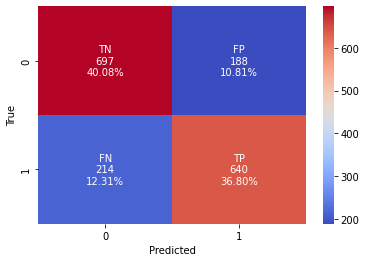


type I error probabilty  : 0.227053
type II error probabilty : 0.234907


-- classification report --
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       885
           1       0.77      0.75      0.76       854

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739



In [61]:
eval_model(target_test,pred)

In [67]:
param_xgb = {
    'learning_rate': [0.01, 0.05, 0.3], # 경사하강법 : '매개변수' -> 최소오차 -> 보폭 크기
    'max_depth': [3, 5, 7], # 트리의 깊이 (오버피팅)
    'subsample': [0.3, 0.5, 1], # 추출할 데이터 비율
    'n_estimators': [300, 600] # 트리 개수
}
#param_lgb = {
#    'learning_rate' : [0.01, 0.05, 0.1, 0.2],
#    'max_depth' : [3, 5, 7, 10],
#    'n_estimators' : [200, 300, 500, 700],
#    'num_leaves' : [100, 300, 500, 700],
#}

In [68]:
from sklearn.model_selection import GridSearchCV
model_xgb = xgb.XGBClassifier()
#model_lgb = lgb.LGBMClassifier()
gs_model_xgb = GridSearchCV(model, param_xgb, n_jobs=-1, scoring='f1', cv = 5)
#gs_model_lgb = GridSearchCV(model, param_lgb, n_jobs=-1, scoring='f1', cv = 5)
gs_model_xgb.fit(input_train, target_train)
#gs_model_lgb.fit(input_train, target_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(max_depth=19, n_estimators=500,
                                     random_state=100),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.3],
                         'max_depth': [3, 5, 7], 'n_estimators': [300, 600],
                         'subsample': [0.3, 0.5, 1]},
             scoring='f1')

In [69]:
print(f'최적 XGB 파라미터 : {gs_model_xgb.best_params_}')
print(f'XGB 예측정확도 : {gs_model_xgb.best_score_}')
#print(f'최적 LGB 파라미터 : {gs_model_lgb.best_params_}')
#print(f'LGB 예측정확도 : {gs_model_lgb.best_score_}')

최적 XGB 파라미터 : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 600, 'subsample': 1}
XGB 예측정확도 : 0.808621706462638


In [70]:
joblib.dump(gs_model_xgb, 'gs_model_xgb.pkl')
pred_xgb = gs_model_xgb.predict(input_test)
print(f"accuracy_score : {accuracy_score(target_test, pred_xgb)}")
print(classification_report(target_test, pred_xgb))
# precision : 정밀도
# recall : 재현율
# f1-score : F1-점수
# support : 인덱스

accuracy_score : 0.8079355951696378
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       885
           1       0.78      0.84      0.81       854

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



In [71]:
#joblib.dump(gs_model_lgb, 'gs_model_lgb.pkl')
#pred_lgd = gs_model_lgb.predict(input_test)
#print(f"accuracy_score : {accuracy_score(target_test, pred_lgd)}")
#print(classification_report(target_test, pred_lgd))
# precision : 정밀도
# recall : 재현율
# f1-score : F1-점수
# support : 인덱스

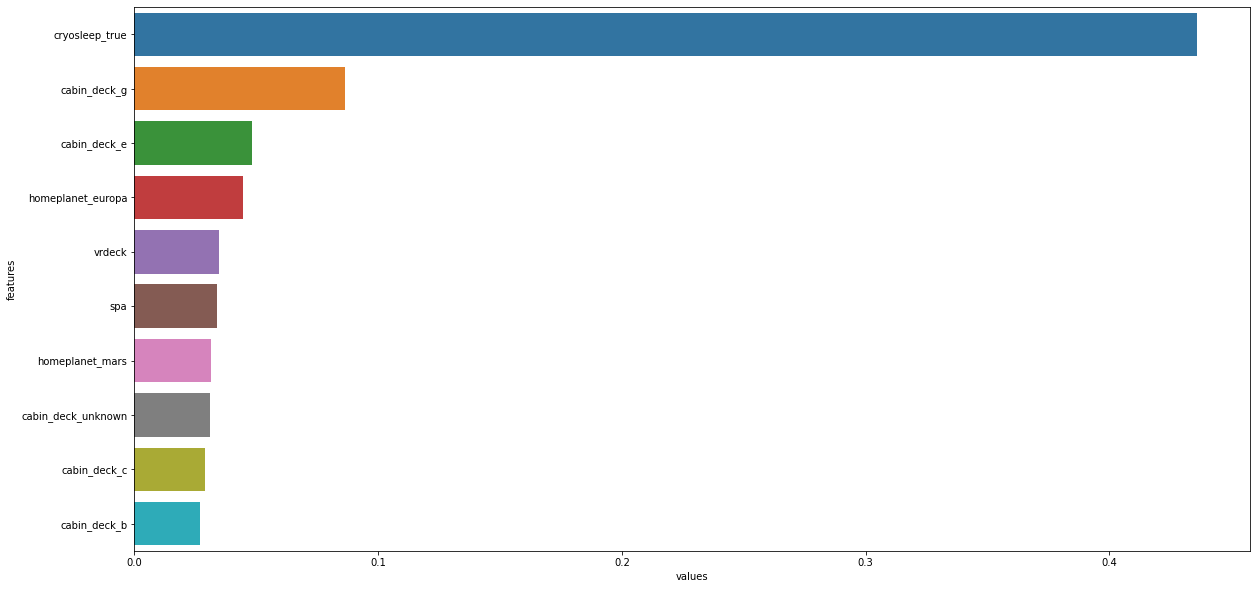

In [74]:
feature_imp = pd.DataFrame({'features': input_train.columns, 'values': model.feature_importances_})
plt.figure(figsize=(20, 10))
sns.barplot(x='values', y='features', data=feature_imp.sort_values(by='values', ascending=False).head(10))

In [ ]:
#feature_imp = pd.DataFrame({'features': input_train.columns, 'values': gs_model_lgb.feature_importances_})
#plt.figure(figsize=(20, 10))
#sns.barplot(x='values', y='features', data=feature_imp.sort_values(by='values', ascending=False).head(10))
# 추가 파라미터에 따라 시간이 2배 ~ 3배 까지도 늘어나며
# gridsearch의 경우 더욱 오랜 시간이 걸린다.